# 时间序列
## 语言
python

## 库
statsmodels

# 程序执行


## 加载库

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import matplotlib.dates as mdates

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import math
import os
import copy

plt.rcParams['font.family'] = ['SimHei']  # 中文字体设置
plt.rcParams['axes.unicode_minus'] = False

## 读取所有数据


data目录下xlsx


In [2]:
path = './data/'
arr = []
for file in os.listdir(path):
    df = pd.read_excel('%s/%s' % (path, file))
    house = df[df['用　　途']=='普通住宅']
    arr.append(house)
df = pd.concat(arr)
df

,发布编号,合同注销,合同编号,成交公司,成交时间,所在区县,街 道,街道(或小区),院门牌号,楼 号,建筑年代,层 数,建筑面积,户 型,装修标准,用 途,成交单价,房屋性质,房屋类型,GONGSI
0,2277139,NaN,C1869763,北京尚诚置地房地产经纪有限公司,2020-01-01 00:00:00,海淀区,清河街道办事处清河,永泰园,无,25号楼,2003.0,1,108.13,其它,精装修,普通住宅,17500,商品房,楼房,NaN
2,2277656,NaN,C1870028,北京我爱我家华熙房地产经纪有限公司,2020-01-01 00:00:00,房山区,NaN,良乡行宫园三里,无,4号楼,1995.0,4,64.99,二室一厅,NaN,普通住宅,28900,商品房,楼房,NaN
3,2277659,NaN,C1870029,北京我爱我家华熙房地产经纪有限公司,2020-01-01 00:00:00,房山区,NaN,良乡苏园小区,无,5号楼,2001.0,3,89.69,其它,NaN,普通住宅,28800,商品房,楼房,NaN
4,2277664,NaN,C1870032,北京我爱我家华熙房地产经纪有限公司,2020-01-01 00:00:00,房山区,NaN,燕化星城,健德二里,26号楼,1996.0,4,76.21,其它,NaN,普通住宅,22000,已购公有住房,楼房,NaN
5,2277666,NaN,C1870036,北京中联时代房地产经纪有限公司,2020-01-01 00:00:00,大兴区,NaN,永兴路,5号院,5号楼,2014.0,23,144.11,四室二厅,NaN,普通住宅,13900,商品房,楼房,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19252,2483777,NaN,C2053574,北京链家置地房地产经纪有限公司,2021-01-31 00:00:00,石景山区,NaN,鲁谷村,无,2号楼,1995.0,1,67.33,三室二厅,NaN,普通住宅,44600,已购公有住房,楼房,NaN
19253,2483301,NaN,C2053134,北京我爱我家房地产经纪有限公司,2021-01-31 00:00:00,海淀区,NaN,清河龙岗路,51号院,1号楼,2000.0,1,49.92,其它,NaN,普通住宅,68500,已购公有住房,楼房,NaN
19254,2484115,NaN,C2053920,北京链家置地房地产经纪有限公司,2021-01-31 00:00:00,朝阳区,NaN,潘家园,无,11号楼,1981.0,1,72.17,其它,NaN,普通住宅,18000,商品房,楼房,NaN
19255,2483782,NaN,C2053577,北京链家置地房地产经纪有限公司,2021-01-31 00:00:00,海淀区,NaN,永定路西里,无,10号楼,1997.0,16,100.6,其它,NaN,普通住宅,92500,已购公有住房,楼房,NaN


## 公共方法


1. 新建表按照"总量"和各个区

In [3]:
def getAllFrame(df, freq):
    """
    获得全部框架
    :param df:  原始dataframe
    :param freq:    频率:天(1D),周(1W),半月(SM),月(1M)
    :return:    dataframe
    """
    combination = pd.Grouper(key='成交时间', freq=freq, origin='2020-01-01')
    total = df.groupby(combination).agg({'成交单价': 'count'})
    total.columns = ['总量']

    zones = df.groupby(['所在区县'])
    alldf = copy.deepcopy(total)
    for name, group in zones:
        zone = group.groupby(combination).agg({'成交单价': 'count'})
        zone.columns = [name]
        alldf = alldf.join(zone)
    alldf

    return alldf

2. 单位根检验（Dickey-Fuller test）

In [4]:
def dickey(df):
    """
    获得全部框架
    :param df:  原始dataframe
    :param freq:    频率:天(1D),周(1W),半月(SM),月(1M)
    :return:    dataframe
    """
    t = adfuller(df)
    output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
    output['value']['Test Statistic Value'] = t[0]
    output['value']['p-value'] = t[1]
    output['value']['Lags Used'] = t[2]
    output['value']['Number of Observations Used'] = t[3]
    output['value']['Critical Value(1%)'] = t[4]['1%']
    output['value']['Critical Value(5%)'] = t[4]['5%']
    output['value']['Critical Value(10%)'] = t[4]['10%']
    return output

## 总数dataframe

# 按照各种频率
1. 月
2. 半月
3. 周
4. 日

In [5]:
monthdf = getAllFrame(df, 'MS')
semidf = getAllFrame(df, 'SMS')
weekdf = getAllFrame(df, 'W')
daydf = getAllFrame(df, 'D')

## 时间序列图表
### 总量图

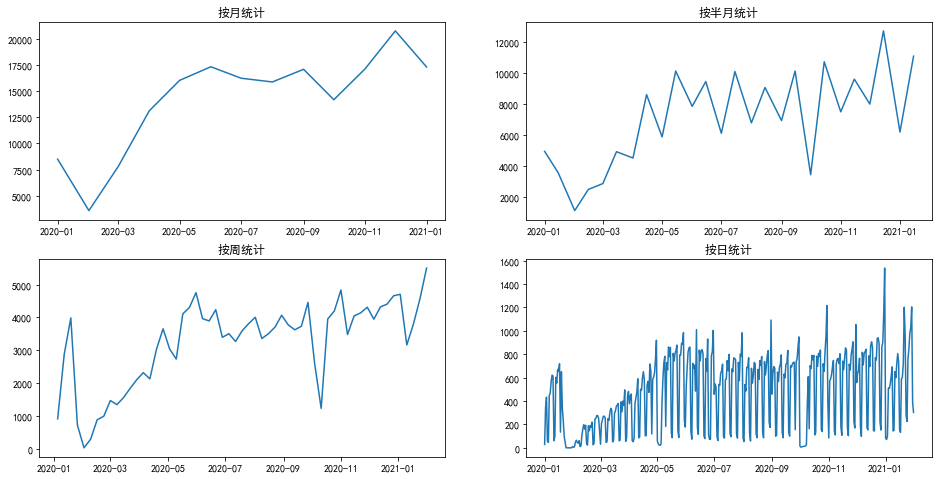

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16,8))
axes[0, 0].set_title('按月统计')
axes[0, 0].plot(monthdf['总量'])
axes[0, 1].set_title('按半月统计')
axes[0, 1].plot(semidf['总量'])
axes[1, 0].set_title('按周统计')
axes[1, 0].plot(weekdf['总量'])
axes[1, 1].set_title('按日统计')
axes[1, 1].plot(daydf['总量'])


### 按区分布

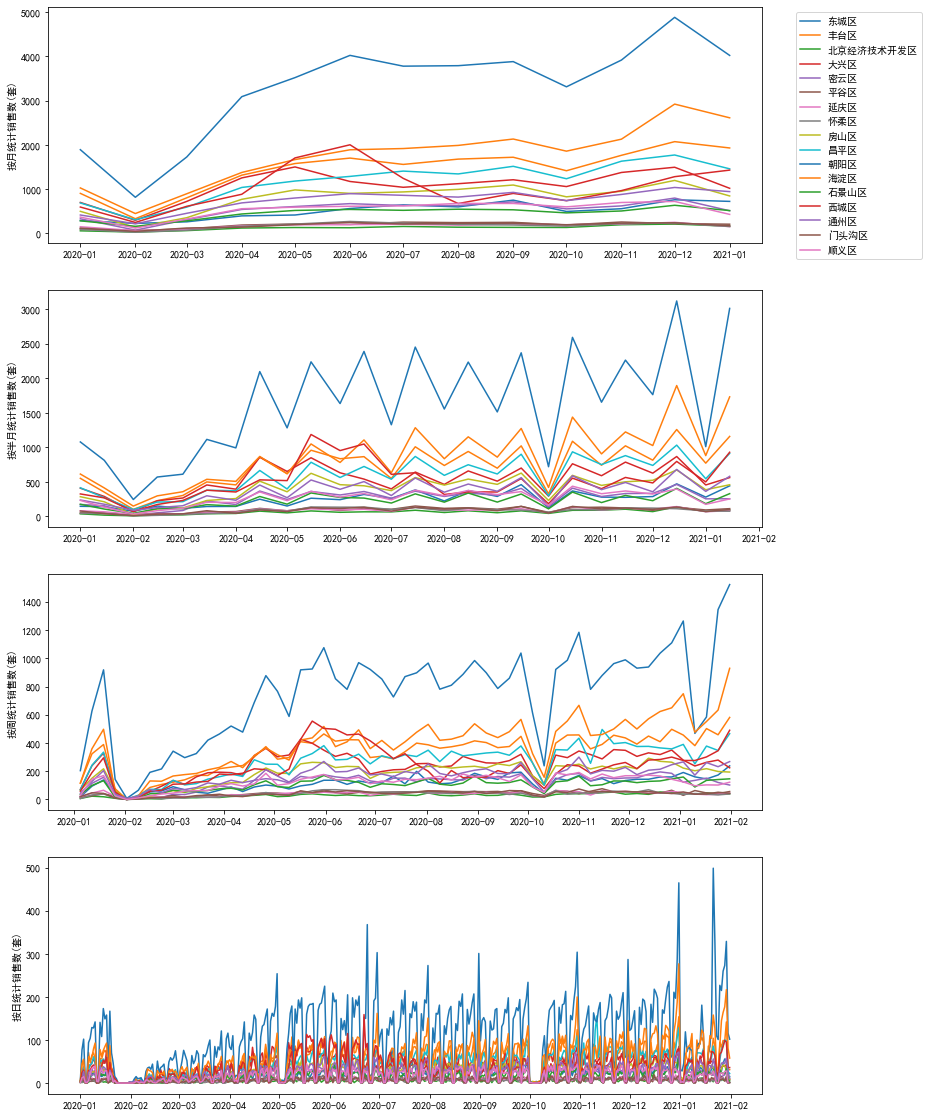

In [7]:
def showAllZones():
    fig, axes = plt.subplots(4, 1, figsize=(16, 20))
    arr = [('按月统计', monthdf), ('按半月统计', semidf), ('按周统计', weekdf), ('按日统计', daydf)]
    for index,data in enumerate(arr):
        df = data[1]
        for name in df.columns:
            if name != '总量':
                axes[index].plot(df[name], label=name)
        box = axes[index].get_position()
        axes[index].set_position([box.x0, box.y0, box.width * 0.8, box.height])
        axes[index].xaxis.set_major_locator(mdates.MonthLocator())
        axes[index].set_ylabel('%s销售数(套)' % data[0])
    axes[0].legend( bbox_to_anchor=(1.04, 1))
    plt.show()
showAllZones()

## 单位根检验（Dickey-Fuller test）


p-value较高，序列具有单位根，即非平稳。

## ARMA(p,q)模型阶次


1. 我们通过观察PACF和ACF截尾，分别判断p、q的值。

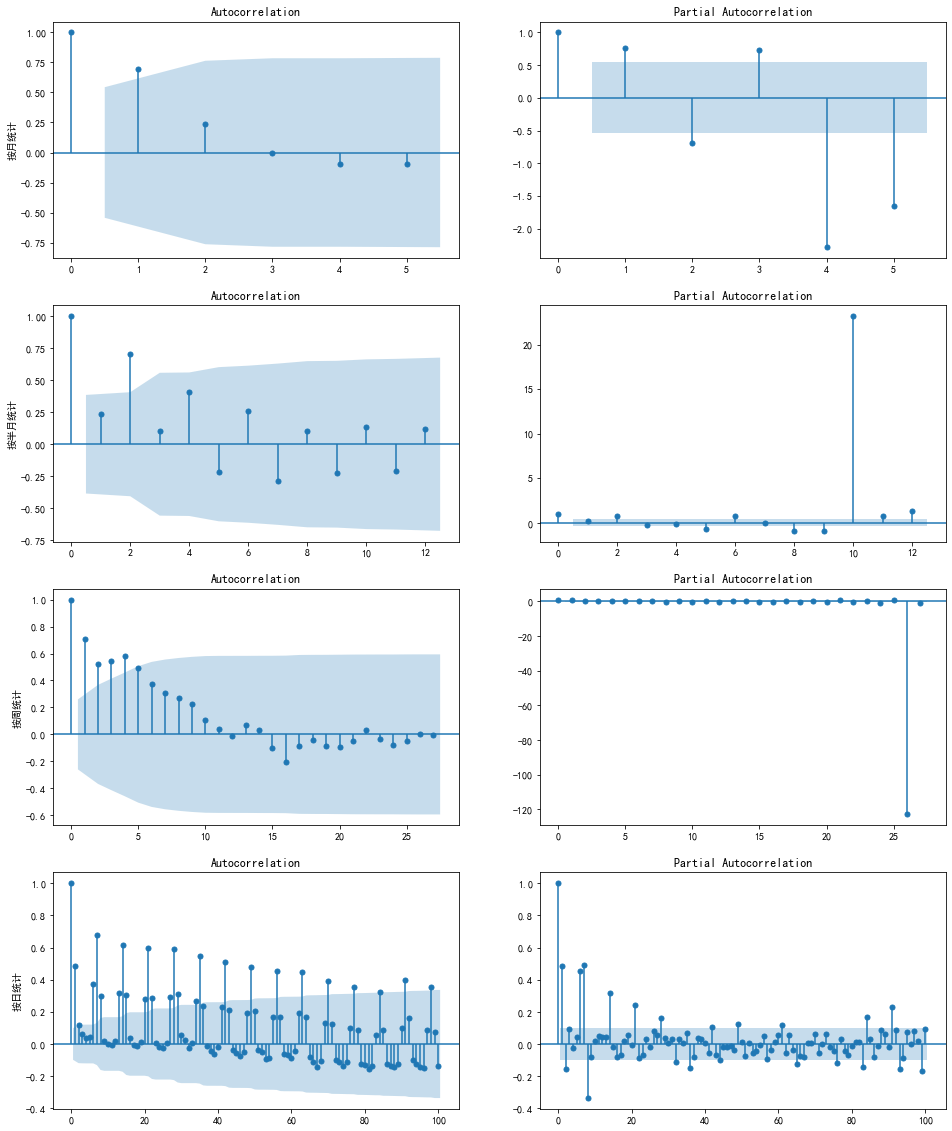

In [8]:
def showAcf():
    fig, axes = plt.subplots(4, 2, figsize=(16, 20))
    arr = [('按月统计', monthdf), ('按半月统计', semidf), ('按周统计', weekdf), ('按日统计', daydf)]
    res = []
    for index,data in enumerate(arr):
        df = data[1]

        num = df.shape[0]
        # nlags = math.floor(num/2) - 1
        # if nlags > 20:
        #     nlags = 20
        # lag_acf = acf(df, nlags=nlags)
        # lag_pacf = pacf(df, nlags=nlags, method='ols')

        lags = math.floor(num/2) - 1
        if lags > 100:
            lags = 100
        plot_acf(df['总量'], lags=lags, ax=axes[index, 0])
        plot_pacf(df['总量'], lags=lags, ax=axes[index, 1])

        axes[index, 0].set_ylabel(data[0])
    plt.show()
showAcf()

## ARMA建模及预测


定阶(order)之后就能构建ARMA模型了

计算模型中系数的置信区间


残差序列的纯随机性的检验


自相关系数


单位根检验

# 按周

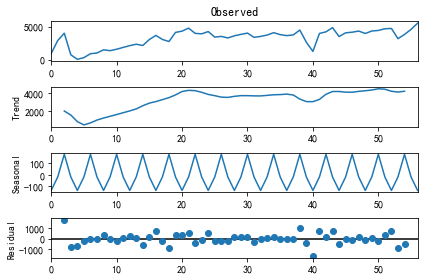

In [9]:
# 得到如下的分解图形——原始数据、趋势数据、周期性数据、随机变量
rd = sm.tsa.seasonal_decompose(weekdf['总量'].values, freq=4)
resplot = rd.plot()

## 单位根检验（Dickey-Fuller test）

p-value较高，序列具有单位根，即非平稳。

In [10]:
dickey(weekdf['总量'])

,value
Test Statistic Value,-1.323177
p-value,0.618503
Lags Used,3
Number of Observations Used,53
Critical Value(1%),-3.560242
Critical Value(5%),-2.91785
Critical Value(10%),-2.596796


如何确定该序列能否平稳呢？主要看：


1%、%5、%10不同程度拒绝原假设的统计值和ADF Test result的比较，ADF Test result同时小于1%、5%、10%即说明非常好地拒绝该假设，本数据中，adf结果（Test Statistic）为-1.323177， 大于三个level的统计值(-3.560242, -2.91785, -2.596796)。


看P-value是否非常接近0.  本数据中，P-value 为 0.618503,不够接近0。


ADF检验的原假设是存在单位根，只要这个统计值是小于1%水平下的数字就可以极显著的拒绝原假设，认为数据平稳。注意，ADF值一般是负的，也有正的，但是它只有小于1%水平下的才能认为是及其显著的拒绝原假设。


对于ADF结果在1% 以上 5%以下的结果，也不能说不平稳，关键看检验要求是什么样子的。


但是对于本例，，数据是显然不平稳的了。

## 所以我们做一阶差分处理


因为p-value值太大，序列非平稳


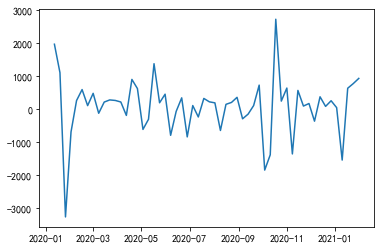

In [11]:
diff = weekdf['总量'].diff(1).dropna()
plt.plot(diff)

## 差分之后再做平稳性检验

In [12]:
dickey(diff)

,value
Test Statistic Value,-7.229506
p-value,0.0
Lags Used,2
Number of Observations Used,53
Critical Value(1%),-3.560242
Critical Value(5%),-2.91785
Critical Value(10%),-2.596796


现在p-value值很低，可以认为序列平稳


## 我们获取一下最佳p和q

In [13]:
sm.tsa.arma_order_select_ic(diff, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=2)

{'aic':             0           1           2
 0         NaN  920.490848  914.225882
 1  922.937106  917.508865  916.173512
 2  915.979224  913.228796  914.307500
 3  911.144204  913.142954  915.136162
 4  913.143041  915.127565  917.111637,
 'bic':             0           1           2
 0         NaN  924.541552  920.301937
 1  926.987810  923.584920  924.274919
 2  922.055279  921.330203  924.434258
 3  919.245611  923.269713  927.288272
 4  923.269800  927.279675  931.289099,
 'aic_min_order': (3, 0),
 'bic_min_order': (3, 0)}

## 构建模型

1. 根据刚才得到的order值设置(3, 0)
2. ARMA模型建模和训练
3. 得到模型评分
4. 绘图得到拟合曲线


观察图形，模型曲线与一阶差分曲线拟合性较好

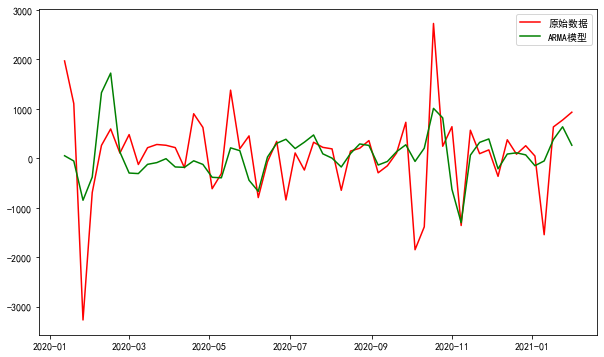

In [14]:
#得到最佳p值和q值
order = (3, 0)
#ARMA模型建模和训练
model = ARMA(diff, order).fit()
#得到模型评分
delta = model.fittedvalues - diff
score = 1- delta.var() / diff.var()
#绘图得到拟合曲线
plt.figure(figsize=(10, 6))
plt.plot(diff, 'r', label='原始数据')
plt.plot(model.fittedvalues, 'g', label='ARMA模型')
plt.legend()
#观察图形，模型曲线与一阶差分曲线拟合性较好

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                     总量   No. Observations:                   56
Model:                     ARMA(3, 0)   Log Likelihood                -451.001
Method:                       css-mle   S.D. of innovations            754.420
Date:                Tue, 02 Feb 2021   AIC                            912.003
Time:                        22:55:20   BIC                            922.130
Sample:                    01-12-2020   HQIC                           915.929
                         - 01-31-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.0508     48.413      1.075      0.282     -42.837     146.938
ar.L1.总量      -0.2564      0.128     -2.005      0.045      -0.507      -0.006
ar.L2.总量      -0.4589      0.121     -3.785      0.000      -0.697      -0.221
ar.L3.总量      -0.4166      0.146     -2.858      0.004      -0.702      -0.131
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.2636           -1.1851j            1.2140           -0.2152
AR.2            0.2636           +1.1851j            1.2140            0.2152
AR.3           -1.6287           -0.0000j            1.6287           -0.5000
-----------------------------------------------------------------------------
"""

In [16]:
model.conf_int()

,0,1
const,-42.836744,146.938260
ar.L1.总量,-0.506901,-0.005814
ar.L2.总量,-0.696540,-0.221259
ar.L3.总量,-0.702244,-0.130937


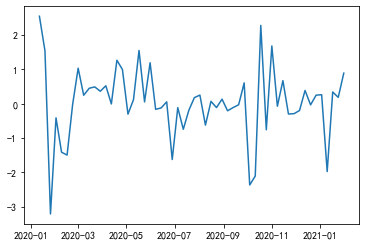

In [17]:
stdresid = model.resid / math.sqrt(model.sigma2)
plt.plot(stdresid)

## 预测未来

In [18]:
p = model.predict(start='2021-02-01', end='2021-5-31')
p

2021-02-07   -748.399412
2021-02-14   -448.188481
2021-02-21    180.621879
2021-02-28    582.109958
2021-03-07     65.559721
2021-03-14   -248.217686
2021-03-21    -97.990004
2021-03-28    222.680142
2021-04-04    202.251191
2021-04-11     -2.250430
2021-04-18    -74.038174
2021-04-25     46.721330
2021-05-02    133.900483
2021-05-09     86.041075
2021-05-16      7.996484
2021-05-23     13.648458
2021-05-30     67.951916
2021-06-06     83.949756
Freq: W-SUN, dtype: float64

## 还原一阶

In [19]:
weekdf['总量'][-1]

5505

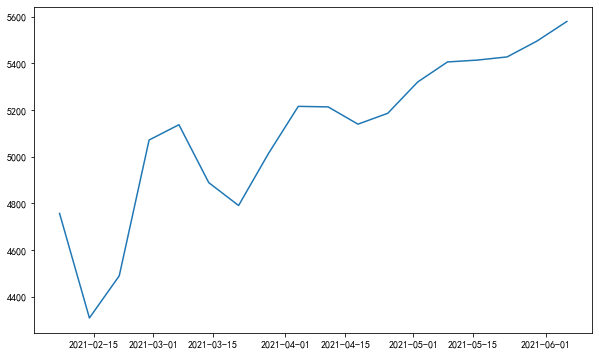

In [20]:
#将差分值进行还原
def revert(diffValues, *lastValue):
    for i in range(len(lastValue)):
        result = []
        lv = lastValue[i]
        for dv in diffValues:
            lv = dv + lv
            result.append(lv)
        diffValues = result
    return diffValues
#需要输入序列的最后一个值   
r = revert(p, 5505)

plt.figure(figsize=(10, 6))
plt.plot(p.index, r)

In [21]:
rdf = pd.DataFrame(r)
rdf.index = p.index
rdf.columns = ['还原数据']
rdf

,还原数据
2021-02-07,4756.600588
2021-02-14,4308.412107
2021-02-21,4489.033987
2021-02-28,5071.143945
2021-03-07,5136.703666
2021-03-14,4888.485980
2021-03-21,4790.495977
2021-03-28,5013.176119
2021-04-04,5215.427310
2021-04-11,5213.176880


# 东城区均价

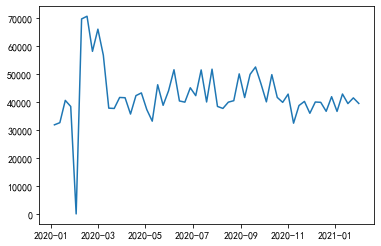

In [22]:
def getDongFrame(df):
    """
    获取东城区均价
    :return:    dataframe
    """
    combination = pd.Grouper(key='成交时间', freq='W', origin='2020-01-01')
    zone = df[(df['所在区县']=='东城区') & (df['房屋性质']=='商品房') & (df['建筑面积'] > 60)]
    zone['成交单价'] = zone['成交单价'].apply(pd.to_numeric)
    res = zone.groupby(combination).agg({'成交单价': 'mean'})
    res['成交单价'] = res['成交单价'].fillna(0) # 补零
    return res
price = getDongFrame(df)
plt.plot(price)

In [23]:
dickey(price)

,value
Test Statistic Value,-3.373595
p-value,0.011893
Lags Used,2
Number of Observations Used,54
Critical Value(1%),-3.557709
Critical Value(5%),-2.91677
Critical Value(10%),-2.596222


In [24]:
sm.tsa.arma_order_select_ic(price, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=2)

C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\thales\.conda\envs\ml\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


{'aic':              0            1            2
 0          NaN  1328.200163  1308.221957
 1  1243.580728  1225.342771  1224.691535
 2  1236.295980  1224.649756  1226.564285
 3  1230.112128  1232.111641          NaN
 4  1232.111791  1247.379948  1334.824314,
 'bic':              0            1            2
 0          NaN  1332.286265  1314.351111
 1  1247.666830  1231.471925  1232.863740
 2  1242.425134  1232.821961  1236.779541
 3  1238.284333  1242.326897          NaN
 4  1242.327047  1259.638255  1349.125673,
 'aic_min_order': (2, 1),
 'bic_min_order': (1, 1)}

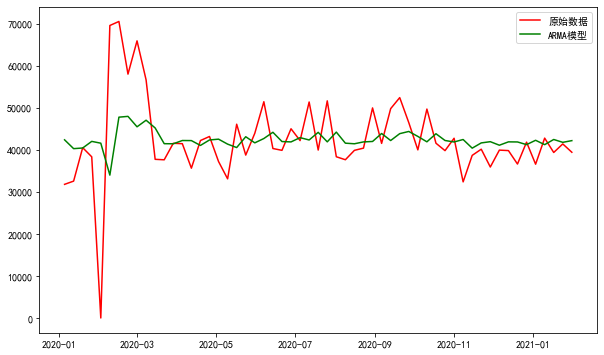

In [25]:
series = price['成交单价']
model = ARMA(price, (1, 0)).fit()
delta = model.fittedvalues - series
score = 1 - delta.var() / series.var()
plt.figure(figsize=(10, 6))
plt.plot(series, 'r', label='原始数据')
plt.plot(model.fittedvalues, 'g', label='ARMA模型')
plt.legend()

## 价格预测

In [26]:
p = model.predict(start='2021-02-01', end='2021-5-31')
p

2021-02-07    41781.678575
2021-02-14    42251.725662
2021-02-21    42344.874199
2021-02-28    42363.333307
2021-03-07    42366.991321
2021-03-14    42367.716224
2021-03-21    42367.859877
2021-03-28    42367.888344
2021-04-04    42367.893986
2021-04-11    42367.895104
2021-04-18    42367.895325
2021-04-25    42367.895369
2021-05-02    42367.895378
2021-05-09    42367.895380
2021-05-16    42367.895380
2021-05-23    42367.895380
2021-05-30    42367.895380
2021-06-06    42367.895380
Freq: W-SUN, dtype: float64

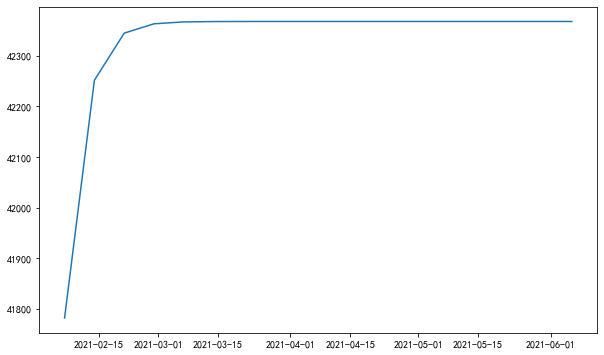

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(p)